# Dataset

Recortando os logos, nessa parte iremos recortar os logos de cada marca como no exemplo mostrado na proxima imagem

In [1]:
datapath = '/home/miguel/Desktop/axurChallange/truedata/'

In [2]:
classes = ['dotz', 'ipiranga', 'magazine', 'original', 'none']

In [3]:
import glob
data_paths = []
for i in classes:
    data_paths = data_paths + glob.glob(datapath+i+"/*.png")

In [4]:
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2 as cv
%matplotlib inline

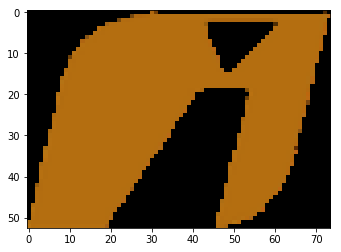

In [5]:
a = data_paths[random.randint(0,len(data_paths)-1)]
a = cv.imread(a)
a_gray = cv.cvtColor(a, cv.COLOR_BGR2GRAY)
plt.imshow(a)

# Gerando dados de treino

Aqui printei diferentes paginas da web, e o objetivo disso é cortar um chunk 100x100 de cada print, e colar o logo em cima dessa imagem em uma posição aleatoria. Iremos fazer isso para gerar os inputs para o modelo que será treinado.

In [6]:
bg0 = cv.imread('/home/miguel/Desktop/axurChallange/truedata/background/0.png')
bg1 = cv.imread('/home/miguel/Desktop/axurChallange/truedata/background/1.png')
bg2 = cv.imread('/home/miguel/Desktop/axurChallange/truedata/background/2.png')
bg_shape = (int(bg0.shape[1]/3), int(bg0.shape[0]/3))
print(bg_shape)
bg0 = cv.resize(bg0, bg_shape)
bg1 = cv.resize(bg1, bg_shape)
bg2 = cv.resize(bg2, bg_shape)
backgrounds = [bg0, bg1, bg2]

(1280, 720)


In [7]:
ip0 = cv.imread('/home/miguel/Desktop/axurChallange/truedata/ipiranga/00.png')
ip1 = cv.imread('/home/miguel/Desktop/axurChallange/truedata/ipiranga/04.png')
ip2 = cv.imread('/home/miguel/Desktop/axurChallange/truedata/ipiranga/05.png')
ip_logos = [ip0, ip1, ip2]

In [8]:
orgn0 = cv.imread('/home/miguel/Desktop/axurChallange/truedata/original/13.png')
orgn1 = cv.imread('/home/miguel/Desktop/axurChallange/truedata/original/16.png')
orgn2 = cv.imread('/home/miguel/Desktop/axurChallange/truedata/original/7.png')
orgn3 = cv.imread('/home/miguel/Desktop/axurChallange/truedata/original/11.png')
orgn4 = cv.imread('/home/miguel/Desktop/axurChallange/truedata/original/15.png')
orgn5 = cv.imread('/home/miguel/Desktop/axurChallange/truedata/original/12.png')
orgn_logos = [orgn0, orgn1, orgn2, orgn3, orgn4, orgn5]

In [9]:
dotz0 = cv.imread('/home/miguel/Desktop/axurChallange/truedata/dotz/16.png')
dotz1 = cv.imread('/home/miguel/Desktop/axurChallange/truedata/dotz/17.png')
dotz2 = cv.imread('/home/miguel/Desktop/axurChallange/truedata/dotz/19.png')
dotz3 = cv.imread('/home/miguel/Desktop/axurChallange/truedata/dotz/18.png')
dotz_logos = [dotz0, dotz1, dotz2, dotz3]

In [10]:
mag0 = cv.imread('/home/miguel/Desktop/axurChallange/truedata/magazine/20.png')
mag1 = cv.imread('/home/miguel/Desktop/axurChallange/truedata/magazine/21.png')
mag2 = cv.imread('/home/miguel/Desktop/axurChallange/truedata/magazine/23.png')
mag3 = cv.imread('/home/miguel/Desktop/axurChallange/truedata/magazine/24.png')
mag_logos = [mag0, mag1, mag2, mag3]

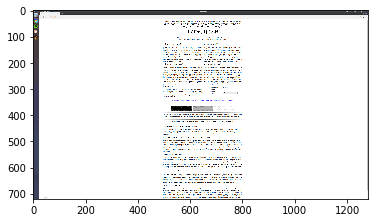

In [11]:
plt.imshow(bg0)

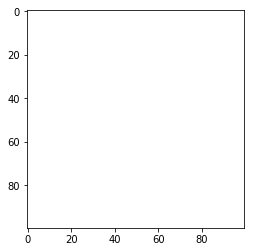

In [12]:
def crop_img(img):
    y, x = img.shape[0]-100, img.shape[1]-100
    point_y = random.randint(0,y)
    point_x = random.randint(0,x)
    return img[point_y:point_y+100, point_x:point_x+100]
example = crop_img(bg0)
plt.imshow(example)

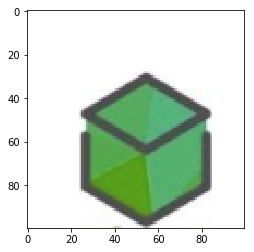

In [13]:
def join_images(bg, logo):
    size = random.randint(20, 80)
    proportion = logo.shape[0]/logo.shape[1]
    img1 = cv.resize(logo, (size, int(size*proportion)))
    offsetx = random.randint(0, 100-size)
    offsety = random.randint(0, 100-int(size*proportion))
    img2 = np.copy(bg)
    img2[offsety:offsety+int(size*proportion), offsetx:offsetx+size] = img1
    return img2
plt.imshow(join_images(example, orgn0))

In [14]:
def batch_generator(size, bgs, original, magazine, dotz, ipiranga):
    training_data = []
    training_labels = []
    for i in range(size):
        _ = random.randint(0,4)
        if _ == 0:#ipiranga
            logo = random.choice(ipiranga)
            bg = crop_img(random.choice(bgs))
            img = join_images(bg, logo)
            label = [1, 0, 0, 0, 0]
        elif _ == 1:#magazine
            logo = random.choice(magazine)
            bg = crop_img(random.choice(bgs))
            img = join_images(bg, logo)
            label = [0, 1, 0, 0, 0]
        elif _ == 2:#dotz
            logo = random.choice(dotz)
            bg = crop_img(random.choice(bgs))
            img = join_images(bg, logo)
            label = [0, 0, 1, 0, 0]
        elif _ == 3:#original
            logo = random.choice(original)
            bg = crop_img(random.choice(bgs))
            img = join_images(bg, logo)
            label = [0, 0, 0, 1, 0]
        else:
            img = crop_img(random.choice(bgs))
            label = [0, 0, 0, 0, 1]
        training_data.append(img)
        training_labels.append(label)
    return training_data, training_labels

In [15]:
traindata, trainlabel = batch_generator(10, backgrounds, orgn_logos, mag_logos, dotz_logos, ip_logos)

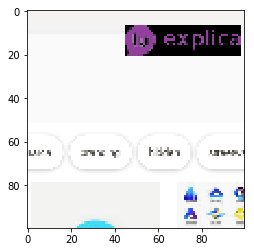

In [16]:
plt.imshow(traindata[random.randint(0,9)])

# Modelo

Para construir o modelo achei melhor usar o tfSlim. O modelo foi montado baseado no modelo da VGG-16, porém fiz algumas alterações não somente no tamanho dos inputs e outputs, mas tambem nas camadas internas da rede. O obejtivo do modelo é usar uma imagem 100x100x3 como entrada e fazer classificação de classe única. As classes são 'dotz', 'magazine luiza', 'original', 'ipiranga', 'nenhum'.

In [17]:
import tensorflow as tf
import tensorflow.contrib.slim as slim

In [18]:
model_input = tf.placeholder(tf.float32, shape=[None, 100, 100, 3], name='input')
labels = tf.placeholder(tf.float32, shape=[None, 5], name='labels')
learning_rate = tf.placeholder('float', [])

In [19]:
def vgg16(inputs):
  with slim.arg_scope([slim.conv2d, slim.fully_connected],
                      activation_fn=tf.nn.relu,
                      weights_initializer=tf.truncated_normal_initializer(0.0, 0.01),
                      weights_regularizer=slim.l2_regularizer(0.0005)):
    net = slim.repeat(inputs, 2, slim.conv2d, 32, [9, 9], scope='conv1')
    print(net.shape)
    net = slim.max_pool2d(net, [2, 2], scope='pool1')
    print(net.shape)
    net = slim.repeat(net, 3, slim.conv2d, 64, [7, 7], scope='conv2')
    print(net.shape)
    net = slim.max_pool2d(net, [2, 2], scope='pool2')
    print(net.shape)
    net = slim.repeat(net, 2, slim.conv2d, 128, [5, 5], scope='conv3')
    print(net.shape)
    net = slim.max_pool2d(net, [2, 2], scope='pool5')
    print(net.shape)
    net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv4')
    print(net.shape)
    net = slim.max_pool2d(net, [2, 2], scope='pool6')
    print(net.shape)
    net = slim.flatten(net)
    print(net.shape)
    net = slim.fully_connected(net, 2096, scope='fc6')
    print(net.shape)
    net = slim.dropout(net, 0.5, scope='dropout6')
    print(net.shape)
    net = slim.fully_connected(net, 536, scope='fc7')
    print(net.shape)
    net = slim.dropout(net, 0.5, scope='dropout7')
    print(net.shape)
    net = slim.fully_connected(net, 5, activation_fn=tf.nn.sigmoid, scope='fc8')
    print(net.shape)
  return net

In [20]:
prediction = vgg16(model_input)

(?, 100, 100, 32)
(?, 50, 50, 32)
(?, 50, 50, 64)
(?, 25, 25, 64)
(?, 25, 25, 128)
(?, 12, 12, 128)
(?, 12, 12, 128)
(?, 6, 6, 128)
(?, 4608)
(?, 2096)
(?, 2096)
(?, 536)
(?, 536)
(?, 5)


In [21]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.squeeze(labels), logits=tf.squeeze(prediction)))
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [22]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [25]:
batch_size = 400
steps = 1000
rate = 0.00005

In [26]:
ac_list = []
lss_list = []

with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        batch_x, batch_y = batch_generator(batch_size, backgrounds, orgn_logos, mag_logos, dotz_logos, ip_logos)
        feed = {model_input:batch_x, labels:batch_y, learning_rate:rate}
        sess.run(train, feed_dict=feed)
        
        if i%100 == 0:
            batch_x, batch_y = batch_generator(batch_size, backgrounds, orgn_logos, mag_logos, dotz_logos, ip_logos)
            feed = {model_input:batch_x, labels:batch_y}
            plot_loss = sess.run(loss, feed_dict=feed)
#             print(sess.run(prediction, feed_dict=feed))
            matches = tf.equal(tf.argmax(prediction, 1), tf.argmax(batch_y, 1))
            acc = tf.reduce_mean(tf.cast(matches, tf.float32))
            plot_accuracy = sess.run(acc, feed_dict=feed)
#             print(batch_y)
            print('Step: {}, Loss: {}, Acc {}'.format(i, plot_loss, plot_accuracy))
            
    location = './saved_models/modelo.ckpt'
    save_path = (saver.save(sess, location))
    print('model saved in', location)

Step: 0, Loss: 1.6094378232955933, Acc 0.20499999821186066
Step: 100, Loss: 1.4454768896102905, Acc 0.3425000011920929
Step: 200, Loss: 1.3976227045059204, Acc 0.4050000011920929
Step: 300, Loss: 1.2632324695587158, Acc 0.5975000262260437
Step: 400, Loss: 1.1594420671463013, Acc 0.6725000143051147
Step: 500, Loss: 1.0899348258972168, Acc 0.7524999976158142
Step: 600, Loss: 1.0861692428588867, Acc 0.7425000071525574
Step: 700, Loss: 1.062652587890625, Acc 0.7250000238418579
Step: 800, Loss: 1.0708619356155396, Acc 0.7400000095367432
Step: 900, Loss: 1.0425947904586792, Acc 0.7674999833106995
Step: 1000, Loss: 1.0378551483154297, Acc 0.7475000023841858
Step: 1100, Loss: 1.0215345621109009, Acc 0.7850000262260437
Step: 1200, Loss: 1.0247693061828613, Acc 0.7749999761581421
Step: 1300, Loss: 1.0023910999298096, Acc 0.7699999809265137
Step: 1400, Loss: 1.0163757801055908, Acc 0.7825000286102295
Step: 1500, Loss: 1.0188515186309814, Acc 0.7649999856948853
Step: 1600, Loss: 1.0514529943466187

KeyboardInterrupt: 